# Part 2: Image Mosaics

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 2.1. Getting Correspondences and Compute the Homography Parameters
1. Getting Correspondences

In [2]:
def get_correspondences(image_1, image_2):
	# Detect SIFT keypoints and descriptors
	sift = cv2.SIFT_create()
	keypoints1, descriptors1 = sift.detectAndCompute(image_1, None)
	keypoints2, descriptors2 = sift.detectAndCompute(image_2, None)

	# Match descriptors using KNN with ratio test
	bf = cv2.BFMatcher(cv2.NORM_L2)
	matches = bf.knnMatch(descriptors1, descriptors2, k=2)

	# Apply ratio test
	good_matches = []
	for m, n in matches:
		if m.distance < 0.75 * n.distance:
			good_matches.append(m)

	# Select top 50 matches
	good_matches = sorted(good_matches, key=lambda x: x.distance)[:50]

	return good_matches, keypoints1, keypoints2


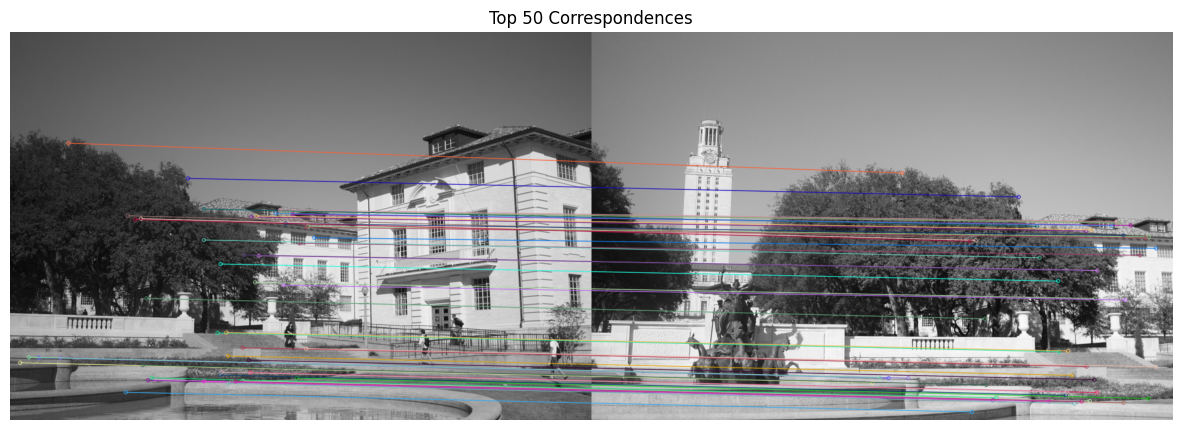

In [3]:
# Paths to the images
img_1_path = r'.\assignment_2_materials\pano_image1.jpg'
img_2_path = r'.\assignment_2_materials\pano_image2.jpg'

# Load the images
img_1 = cv2.imread(img_1_path, cv2.IMREAD_GRAYSCALE)
img_2 = cv2.imread(img_2_path, cv2.IMREAD_GRAYSCALE)

good_matches, keypoints1, keypoints2 = get_correspondences(img_1, img_2)

# Draw matches
result_img = cv2.drawMatches(img_1, keypoints1, img_2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matches
plt.figure(figsize=(15, 10))
plt.imshow(result_img)
plt.title("Top 50 Correspondences")
plt.axis("off")
plt.show()

2. Compute the Homography Parameters

In [4]:
def compute_homography(src_points, dst_points):
    A = []
    for i in range(len(src_points)):
        x, y = src_points[i]
        x_prime, y_prime = dst_points[i]
        A.append([-x, -y, -1, 0, 0, 0, x * x_prime, y * x_prime, x_prime])
        A.append([0, 0, 0, -x, -y, -1, x * y_prime, y * y_prime, y_prime])
    A = np.array(A)
    _, _, V = np.linalg.svd(A)
    H = V[-1].reshape(3, 3)
    return H / H[2, 2]

In [5]:
# Extract corresponding points
src_points = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
dst_points = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

# Compute homography
H = compute_homography(src_points, dst_points)

print("Homography Matrix:\n", H)

Homography Matrix:
 [[ 7.57116719e-01  3.98640725e-02  4.47109470e+02]
 [-1.38420248e-01  9.10757584e-01  7.67289861e+01]
 [-2.18007838e-04 -3.10667074e-05  1.00000000e+00]]


Test Mapping

In [6]:
# Function to map points using the homography matrix
def map_points(H, points):
    # Convert to homogeneous coordinates
    points_homogeneous = np.hstack([points, np.ones((points.shape[0], 1))])
    mapped_points = H @ points_homogeneous.T
    # Convert back to 2D
    mapped_points /= mapped_points[2]
    return mapped_points[:2].T

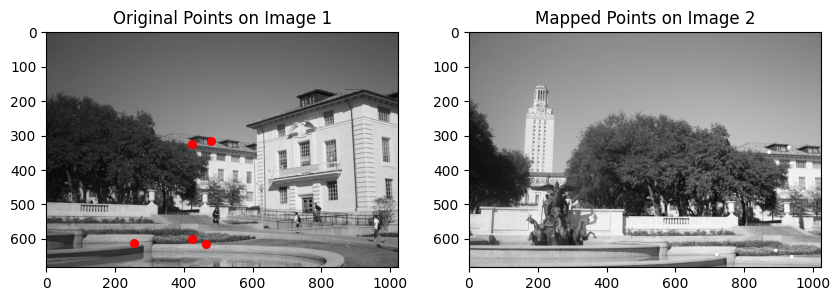

Distance Errors between Mapped Points and True Points:
 [0.28763787 0.23110278 0.03100003 0.32266802 0.31052077]
Mean Error: 0.23658589570348304


In [7]:
# Select a few points to test the homography
test_src_points = src_points[:5]  # Select the first 5 points for testing
mapped_points = map_points(H, test_src_points)

image_2 = img_2.copy()

# Visualize the original points and mapped points on the destination image
for pt in mapped_points:
    cv2.circle(image_2, (int(pt[0]), int(pt[1])), 5, (255, 0, 0), -1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_1, cmap='gray')
plt.title("Original Points on Image 1")
for pt in test_src_points:
    plt.scatter(pt[0], pt[1], color='red', s=30)
    
plt.subplot(1, 2, 2)
plt.imshow(image_2, cmap='gray')
plt.title("Mapped Points on Image 2")
plt.show()

# Verify by comparing distances between corresponding points
test_dst_points = dst_points[:5]
distance_error = np.linalg.norm(mapped_points - test_dst_points, axis=1)
print("Distance Errors between Mapped Points and True Points:\n", distance_error)
print("Mean Error:", np.mean(distance_error))

## 2.2. Warping Between Image Planes
1. Forward Warping

In [8]:
def forward_warp(image, transformation_matrix):
    # Get the dimensions of the input image
    h, w = image.shape[:2]
    is_color = len(image.shape) == 3  # Check if the image is color

    # Define the corners of the image
    corners = np.array([[0, 0, 1],
                        [w - 1, 0, 1],
                        [0, h - 1, 1],
                        [w - 1, h - 1, 1]]).T  # Shape (3, 4)

    # Apply the homography to the corners
    transformed_corners = transformation_matrix @ corners
    transformed_corners /= transformed_corners[2, :]  # Normalize by the third row

    # Get the new bounding box
    min_x = int(np.floor(np.min(transformed_corners[0, :]))) 
    max_x = int(np.ceil(np.max(transformed_corners[0, :])))
    min_y = int(np.floor(np.min(transformed_corners[1, :])))
    max_y = int(np.ceil(np.max(transformed_corners[1, :])))

    # Calculate the size of the new image
    output_width = max_x - min_x
    output_height = max_y - min_y
    
    # Shift to ensure positive coordinates
    offset_x = -int(np.floor(min_x))
    offset_y = -int(np.floor(min_y))

	# Create an output image (black by default)
    if is_color:
        warped = np.zeros((output_height, output_width, 3), dtype=image.dtype)
    else:
        warped = np.zeros((output_height, output_width), dtype=image.dtype)

    # Apply forward warping to each pixel
    for y in range(h):
        for x in range(w):
            source = np.array([x, y, 1])  # Homogeneous coordinates
            dest = transformation_matrix @ source
            dest = dest[:2] / dest[2]  # Normalize homogeneous coordinates
            
            dest_x = int(round(dest[0] + offset_x))
            dest_y = int(round(dest[1] + offset_y))
            
            if 0 <= dest_x < output_width and 0 <= dest_y < output_height:
                warped[dest_y, dest_x] = image[y, x]
    
    return warped, min_x, min_y, max_x, max_y


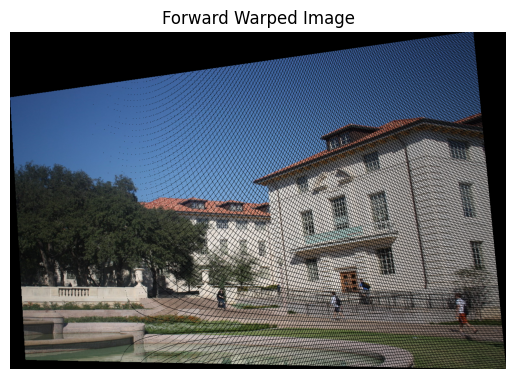

In [11]:
first=cv2.imread(img_1_path)
first_rgb = cv2.cvtColor(first, cv2.COLOR_BGR2RGB)
second=cv2.imread(img_2_path)
second_rgb = cv2.cvtColor(second, cv2.COLOR_BGR2RGB)

warped_image1,x, y, z, w = forward_warp(first_rgb,H)

plt.imshow(warped_image1)
plt.title("Forward Warped Image")
plt.axis('off')
plt.show()

2. Inverse Warping

In [9]:
def bilinear_interpolate(channel, x, y):
    
    # Perform bilinear interpolation for a single channel at the given coordinates (x, y).
    x0 = int(np.floor(x))
    x1 = min(x0 +1, channel.shape[1] -1)
    y0 = int(np.floor(y))
    y1 = min(y0 + 1, channel.shape[0] - 1)

    dx = x - x0
    dy = y - y0

    # Get pixel values
    top_left = channel[y0, x0]
    top_right = channel[y0, x1]
    bottom_left = channel[y1, x0]
    bottom_right = channel[y1, x1]

    # Compute interpolated value
    return (
        (1 - dx) * (1 - dy) * top_left+
        dx * (1 - dy) * top_right +
        (1 - dx) * dy * bottom_left +
        dx * dy * bottom_right
    )

In [10]:
def warp_image_with_homography(image, H):
	# Get the dimensions of the input image
	h, w = image.shape[:2]
	is_color = len(image.shape) == 3  # Check if the image is color

	# Inverse the homography for backward mapping
	inv_H = np.linalg.inv(H)
	warped_image, min_x, min_y, max_x, max_y = forward_warp(image, H)

	# Perform the warping
	for y in range(warped_image.shape[0]):
		for x in range(warped_image.shape[1]):
			# Map the black pixels of the output image coordinates to the input image using the inverse homography
			if warped_image[y, x].all() == 0:
				target_coords = np.array([x+min_x, y+min_y, 1]) # Homogeneous coordinates
				original_coords = inv_H @ target_coords
				original_coords /= original_coords[2]  # Normalize to (x, y, 1)

				orig_x, orig_y = original_coords[:2]

				# Perform bilinear interpolation if within bounds
				if 0 <= orig_x < w and 0 <= orig_y < h:
					if is_color:
						for c in range(3):  # Process each color channel
							warped_image[y, x, c] = bilinear_interpolate(image[:, :, c], orig_x, orig_y)
					else:
						warped_image[y, x] = bilinear_interpolate(image, orig_x, orig_y)

	return warped_image, min_x, min_y, max_x, max_y


Test Forward Warping

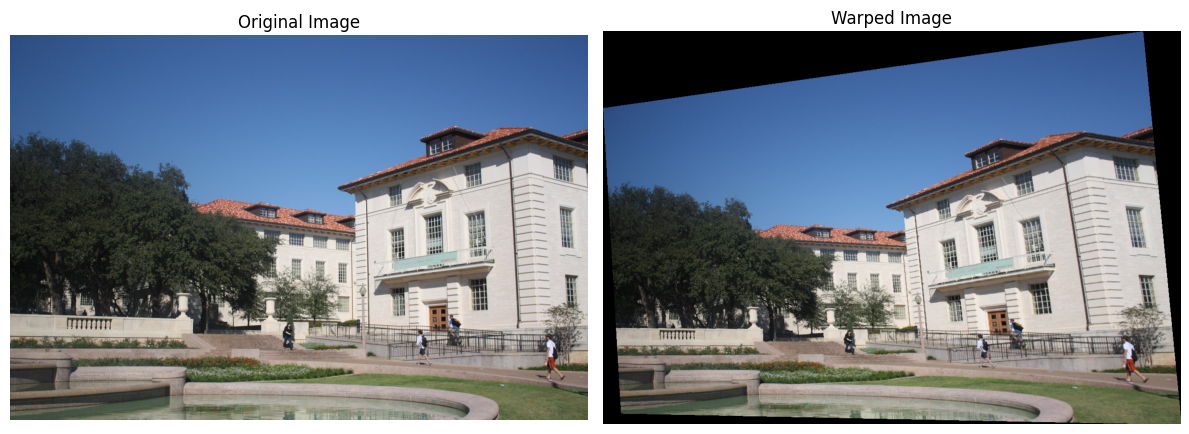

True

In [12]:
# Warp the image
warped, min_x, min_y, max_x, max_y = warp_image_with_homography(first_rgb, H)

plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(first_rgb)
plt.title("Original Image")
plt.axis('off')

# Warped Image
plt.subplot(1, 2, 2)
plt.imshow(warped)
plt.title("Warped Image")
plt.axis('off')

plt.tight_layout()
plt.show()

# Save or display the result
warped2save = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
cv2.imwrite('./Output_Images/Part2_Image1_Warped.jpg', warped2save)

## 2.3. Create the output mosaic

In [13]:
def create_image_mosaic(image1, warped_image, min_x, min_y, max_x, max_y):
    
	# Create a blank mosaic with the same number of channels as the input images
	height, width = (max(warped_image.shape[0],image1.shape[0]), abs(max_x))
	
	if len(image1.shape) == 3 and len(warped_image.shape) == 3:
		mosaic = np.zeros((height, width, 3), dtype=np.uint8)
	else:
		mosaic = np.zeros((height, width), dtype=np.uint8)

	# Overlay warped_image onto the mosaic where it has data
	mask = (warped_image > 0).any(axis=-1) if warped_image.ndim == 3 else (warped_image > 0)

	# Identify the indices of non-black pixels in the mask
	non_black_indices = np.where(mask)

	# Loop through the non-black indices and shift them upwards
	for i, j in zip(*non_black_indices):  # i and j are the row and column indices
		new_i = i
		new_j = j + abs(min_x)	# Shift the colum index to the right
		if new_i >= 0 and new_j >= 0:  # Ensure the new row index is within bounds
			mosaic[new_i, new_j] = warped_image[i, j]

	# Overlay the image
	shift = abs(min_y)
	mosaic[shift: image1.shape[0]+shift, : image1.shape[1]] = image1

	return mosaic


True

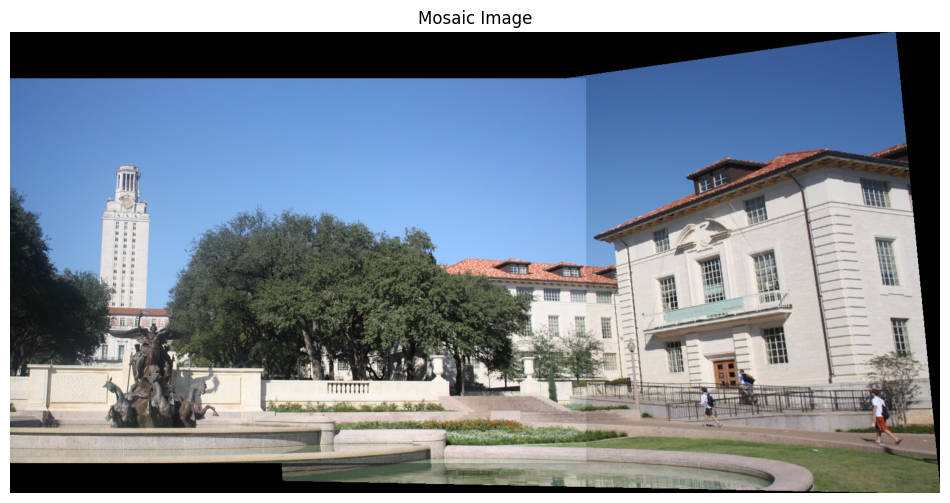

In [14]:
# Create the mosaic
mosaic = create_image_mosaic(second_rgb, warped, min_x, min_y, max_x, max_y)

# Mosaic
plt.figure(figsize=(12, 6))
plt.imshow(mosaic)
plt.title("Mosaic Image")
plt.axis('off')
cv2.waitKey(0)
cv2.destroyAllWindows()

# Save the result
mosaic2save = cv2.cvtColor(mosaic, cv2.COLOR_BGR2RGB)
cv2.imwrite('./Output_Images/Part2_Mosaic_Image.jpg', mosaic2save)

# Another Example
## 2.1. Getting Correspondences and Compute the Homography Parameters
1. Getting Correspondences

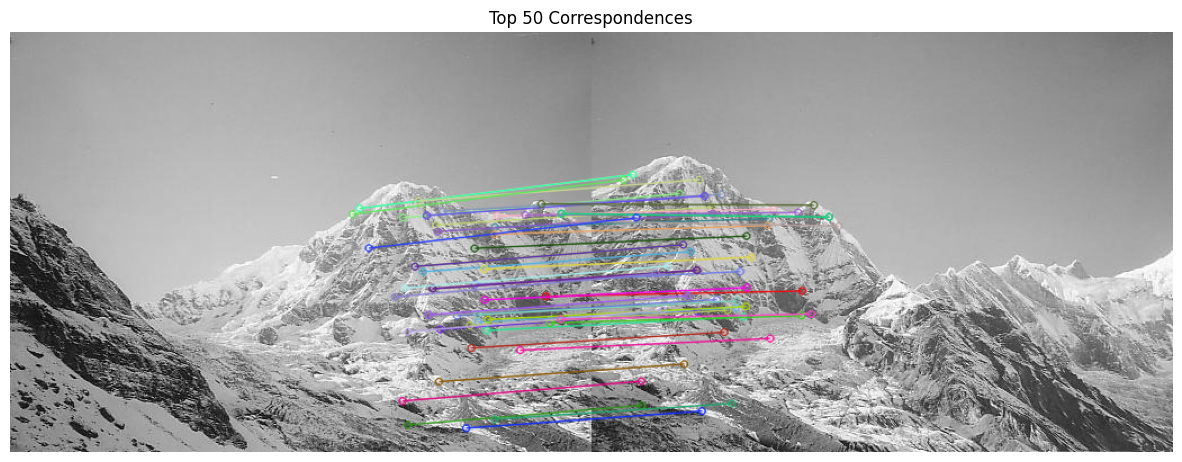

In [16]:
# Paths to the images
first_view_path = r'.\assignment_2_materials\first_view.jpg'
second_view_path = r'.\assignment_2_materials\second_view.jpg'

# Load the images
first_view = cv2.imread(first_view_path, cv2.IMREAD_GRAYSCALE)
second_view = cv2.imread(second_view_path, cv2.IMREAD_GRAYSCALE)

good_matches, keypoints1, keypoints2 = get_correspondences(first_view, second_view)

# Draw matches
result_img = cv2.drawMatches(first_view, keypoints1, second_view, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matches
plt.figure(figsize=(15, 10))
plt.imshow(result_img)
plt.title("Top 50 Correspondences")
plt.axis("off")
plt.show()

2. Compute the Homography Parameters

In [17]:
# Extract corresponding points
src_points = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
dst_points = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

# Compute homography
H = compute_homography(src_points, dst_points)

print("Homography Matrix:\n", H)

Homography Matrix:
 [[ 1.66279468e+00 -3.03556299e-01 -4.16000689e+02]
 [ 4.85390129e-01  1.47208233e+00 -2.02853835e+02]
 [ 1.36627576e-03 -9.64138756e-05  1.00000000e+00]]


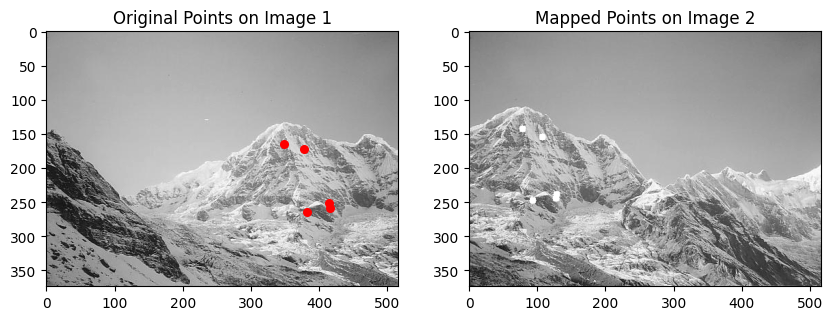

Distance Errors between Mapped Points and True Points:
 [0.45651915 0.50996077 0.11894365 0.22533778 0.57004361]
Mean Error: 0.3761609892556973


In [18]:
# Select a few points to test the homography
test_src_points = src_points[:5]  # Select the first 5 points for testing
mapped_points = map_points(H, test_src_points)

image_2 = second_view.copy()

# Visualize the original points and mapped points on the destination image
for pt in mapped_points:
    cv2.circle(image_2, (int(pt[0]), int(pt[1])), 5, (255, 0, 0), -1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(first_view, cmap='gray')
plt.title("Original Points on Image 1")
for pt in test_src_points:
    plt.scatter(pt[0], pt[1], color='red', s=30)
    
plt.subplot(1, 2, 2)
plt.imshow(image_2, cmap='gray')
plt.title("Mapped Points on Image 2")
plt.show()

# Verify by comparing distances between corresponding points
test_dst_points = dst_points[:5]
distance_error = np.linalg.norm(mapped_points - test_dst_points, axis=1)
print("Distance Errors between Mapped Points and True Points:\n", distance_error)
print("Mean Error:", np.mean(distance_error))

## 2.2. Warping Between Image Planes
Test Forward Warping

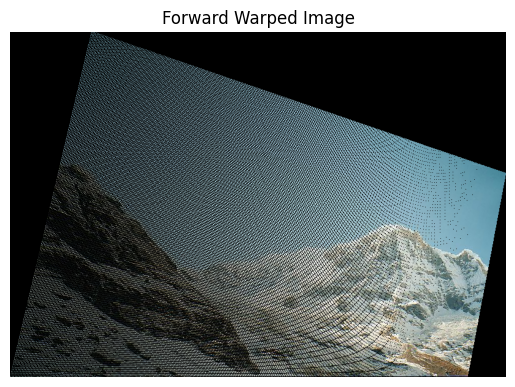

In [19]:
first=cv2.imread(first_view_path)
first_rgb = cv2.cvtColor(first, cv2.COLOR_BGR2RGB)
second=cv2.imread(second_view_path)
second_rgb = cv2.cvtColor(second, cv2.COLOR_BGR2RGB)

warped_image1,x, y, z, w = forward_warp(first_rgb,H)

plt.imshow(warped_image1)
plt.title("Forward Warped Image")
plt.axis('off')
plt.show()

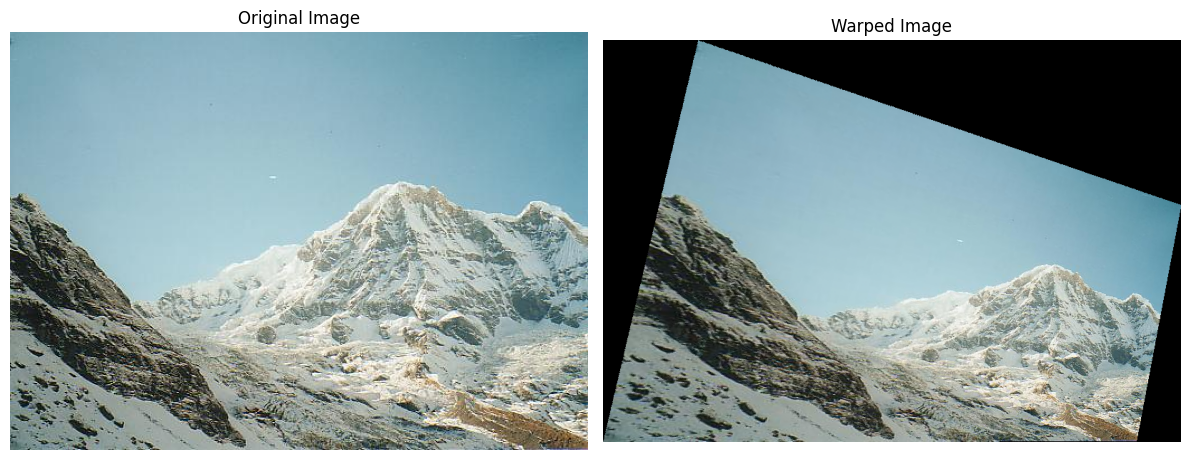

True

In [30]:
# Warp the image
warped, min_x, min_y, max_x, max_y = warp_image_with_homography(first_rgb, H)

plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(first_rgb)
plt.title("Original Image")
plt.axis('off')

# Warped Image
plt.subplot(1, 2, 2)
plt.imshow(warped)
plt.title("Warped Image")
plt.axis('off')

plt.tight_layout()
plt.show()

# Save or display the result
warped2save = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)
cv2.imwrite('./Output_Images/Part2_2nd_Example_1st_View_Warped.jpg', warped2save)

## 2.3. Create the output mosaic

In [21]:
def create_image_mosaic_2(image1, warped_image, min_x, min_y, max_x, max_y):
    # Calculate the height and width of the mosaic
    mosaic_height = max(image1.shape[0] + abs(min_y), warped_image.shape[0])
    mosaic_width = max(image1.shape[1] + abs(min_x), max_x + abs(min_x))

    # Initialize the mosaic with the appropriate number of channels
    if len(image1.shape) == 3 and len(warped_image.shape) == 3:
        mosaic = np.zeros((mosaic_height, mosaic_width, 3), dtype=np.uint8)
    else:
        mosaic = np.zeros((mosaic_height, mosaic_width), dtype=np.uint8)

    # Overlay the warped image onto the mosaic
    mask = (warped_image > 0).any(axis=-1) if warped_image.ndim == 3 else (warped_image > 0)
    non_black_indices = np.where(mask)
     # Overlay the original image onto the mosaic
    shift_y = abs(min_y)
    shift_x = abs(min_x)

    mosaic[shift_y:shift_y + image1.shape[0], shift_x:shift_x +image1.shape[1]] = image1
    for i, j in zip(*non_black_indices):  # i and j are the row and column indices
        new_i = i +int(0.001*abs(min_x))  # Adjust the row index by min_y
        new_j = j -int(0.012*abs(min_y))  # Adjust the column index by min_x

        # Ensure indices are within bounds
        if 0 <= new_i < mosaic.shape[0] and 0 <= new_j < mosaic.shape[1]:
            mosaic[new_i, new_j] = warped_image[i, j]

    return mosaic

True

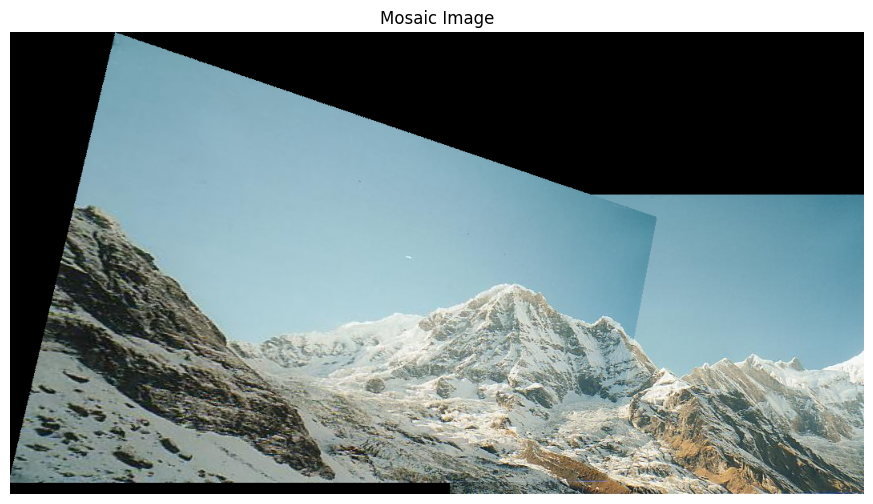

In [28]:
# Create the mosaic
mosaic = create_image_mosaic_2(second_rgb, warped, min_x, min_y, max_x, max_y)

# Mosaic
plt.figure(figsize=(12, 6))
plt.imshow(mosaic)
plt.title("Mosaic Image")
plt.axis('off')
cv2.waitKey(0)
cv2.destroyAllWindows()

# Save the result
mosaic2save = cv2.cvtColor(mosaic, cv2.COLOR_BGR2RGB)
cv2.imwrite('./Output_Images/Part2_2nd_Example_Mosaic_Image.jpg', mosaic2save)